In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==================== РЕАЛІЗАЦІЯ DBSCAN ====================
class DBSCAN:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
    
    def _region_query(self, X, point_index):
        nbrs = NearestNeighbors(radius=self.eps).fit(X)
        return nbrs.radius_neighbors([X[point_index]])[1][0]
    
    def _expand_cluster(self, X, labels, point_index, cluster_id):
        queue = [point_index]
        while queue:
            point_index = queue.pop(0)
            if labels[point_index] == -1:
                labels[point_index] = cluster_id
            if labels[point_index] == 0:
                labels[point_index] = cluster_id
                neighbors = self._region_query(X, point_index)
                if len(neighbors) >= self.min_samples:
                    queue.extend(neighbors)
    
    def fit_predict(self, X):
        labels = np.zeros(len(X), dtype=int)
        cluster_id = 0
        for point_index in range(len(X)):
            if labels[point_index] != 0:
                continue
            neighbors = self._region_query(X, point_index)
            if len(neighbors) < self.min_samples:
                labels[point_index] = -1
            else:
                cluster_id += 1
                self._expand_cluster(X, labels, point_index, cluster_id)
        return labels

# ==================== A/B ТЕСТУВАННЯ ====================
def ab_test_detailed(control_group, treatment_group):
    """Детальне A/B тестування з статистикою"""
    control_mean = np.mean(control_group)
    treatment_mean = np.mean(treatment_group)
    
    control_std = np.std(control_group)
    treatment_std = np.std(treatment_group)
    
    # Z-тест для порівняння пропорцій
    n1, n2 = len(control_group), len(treatment_group)
    pooled_prob = (np.sum(control_group) + np.sum(treatment_group)) / (n1 + n2)
    se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n1 + 1/n2))
    z_score = (treatment_mean - control_mean) / se if se > 0 else 0
    
    improvement = ((treatment_mean - control_mean) / control_mean * 100) if control_mean > 0 else 0
    
    return {
        'control_rate': control_mean,
        'treatment_rate': treatment_mean,
        'control_std': control_std,
        'treatment_std': treatment_std,
        'improvement': improvement,
        'z_score': z_score,
        'winner': 'Treatment' if treatment_mean > control_mean else 'Control'
    }

# ==================== ЗАВАНТАЖЕННЯ ДАНИХ ====================
def load_cybersecurity_data(filepath):
    """Завантаження датасету кібербезпеки"""
    print("\nЗавантаження датасету...")
    print(f"Файл: {filepath}")
    
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Датасет успішно завантажено!")
        print(f"  Розмір: {df.shape[0]} рядків, {df.shape[1]} стовпців")
        
        # Відображення інформації про датасет
        print(f"\nСтовпці датасету:")
        for i, col in enumerate(df.columns, 1):
            print(f"  {i}. {col} ({df[col].dtype})")
        
        print(f"\nПерші 5 рядків:")
        print(df.head())
        
        return df
    
    except FileNotFoundError:
        print(f"✗ Помилка: Файл '{filepath}' не знайдено!")
        print(f"\nІнструкція для завантаження:")
        print(f"1. Перейдіть на https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks")
        print(f"2. Завантажте датасет (потрібен обліковий запис Kaggle)")
        print(f"3. Розпакуйте архів у поточну директорію")
        print(f"4. Вкажіть правильний шлях до CSV файлу")
        return None
    except Exception as e:
        print(f"✗ Помилка при завантаженні: {str(e)}")
        return None

def preprocess_data(df):
    """Препроцесинг даних"""
    print("\n" + "="*70)
    print("ПРЕПРОЦЕСИНГ ДАНИХ")
    print("="*70)
    
    # Виявлення числових та категоріальних стовпців
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nЧислові стовпці ({len(numeric_cols)}): {numeric_cols[:5]}...")
    print(f"Категоріальні стовпці ({len(categorical_cols)}): {categorical_cols}")
    
    # Обробка пропущених значень
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nПропущені значення:")
        print(missing[missing > 0])
        df = df.fillna(df.median(numeric_only=True))
        print(f"✓ Пропущені значення заповнено медіаною")
    else:
        print(f"\n✓ Пропущених значень немає")
    
    # Кодування категоріальних змінних
    label_encoders = {}
    for col in categorical_cols:
        if df[col].nunique() < 50:  # Кодуємо тільки якщо не забагато унікальних значень
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            print(f"✓ Закодовано стовпець '{col}' ({df[col].nunique()} унікальних значень)")
    
    return df, numeric_cols, categorical_cols, label_encoders

# ==================== ДОСЛІДЖЕННЯ DBSCAN ====================
def research_dbscan(df, feature_cols, target_col=None):
    """Дослідження DBSCAN на датасеті"""
    print("\n" + "="*70)
    print("ДОСЛІДЖЕННЯ DBSCAN НА ДАТАСЕТІ КІБЕРБЕЗПЕКИ")
    print("="*70)
    
    # Підготовка даних
    print(f"\nВикористовуються ознаки: {feature_cols[:5]}...")
    X = df[feature_cols].values
    
    # Обмеження розміру вибірки для швидкості (якщо датасет дуже великий)
    if len(X) > 5000:
        print(f"\n⚠ Датасет великий ({len(X)} рядків), використовуємо вибірку з 5000 рядків")
        sample_indices = np.random.choice(len(X), 5000, replace=False)
        X = X[sample_indices]
        df_sample = df.iloc[sample_indices].copy()
    else:
        df_sample = df.copy()
    
    # Нормалізація
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Тестування різних параметрів
    eps_values = [0.3, 0.5, 0.7, 1.0]
    min_samples_values = [5, 10, 15, 20]
    
    print(f"\nТестування різних комбінацій параметрів eps і min_samples...")
    print(f"{'eps':<10}{'min_samples':<15}{'Кластерів':<15}{'Шуму':<15}{'Silhouette':<15}")
    print("-"*70)
    
    best_score = -1
    best_params = None
    best_labels = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Обчислення метрик (якщо є хоча б 2 кластери)
            if n_clusters >= 2 and n_noise < len(labels) - 1:
                try:
                    silhouette = silhouette_score(X_scaled, labels)
                    if silhouette > best_score:
                        best_score = silhouette
                        best_params = (eps, min_samples)
                        best_labels = labels
                except:
                    silhouette = -1
            else:
                silhouette = -1
            
            print(f"{eps:<10}{min_samples:<15}{n_clusters:<15}{n_noise:<15}{silhouette:<15.3f}")
    
    if best_labels is None:
        print("\n⚠ Не вдалося знайти оптимальні параметри, використовуємо eps=0.5, min_samples=10")
        best_params = (0.5, 10)
        dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
        best_labels = dbscan.fit_predict(X_scaled)
        best_score = -1
    
    print("\n" + "="*70)
    print(f"НАЙКРАЩІ ПАРАМЕТРИ: eps={best_params[0]}, min_samples={best_params[1]}")
    if best_score > 0:
        print(f"Silhouette Score: {best_score:.3f}")
    print("="*70)
    
    # Детальний аналіз з найкращими параметрами
    df_sample['cluster'] = best_labels
    
    print("\nСтатистика по кластерах:")
    print("-"*70)
    for cluster_id in sorted(set(best_labels)):
        cluster_data = df_sample[df_sample['cluster'] == cluster_id]
        if cluster_id == -1:
            print(f"\nШум (викиди): {len(cluster_data)} зразків ({len(cluster_data)/len(df_sample)*100:.1f}%)")
        else:
            print(f"\nКластер {cluster_id}: {len(cluster_data)} зразків ({len(cluster_data)/len(df_sample)*100:.1f}%)")
        
        print(f"  Середні значення (перші 3 ознаки):")
        for feature in feature_cols[:3]:
            print(f"    {feature}: {cluster_data[feature].mean():.2f}")
    
    # Якщо є цільова змінна, показуємо розподіл
    if target_col and target_col in df_sample.columns:
        print(f"\nРозподіл '{target_col}' по кластерах:")
        print("-"*70)
        cluster_analysis = pd.crosstab(df_sample['cluster'], df_sample[target_col])
        print(cluster_analysis)
    
    # Візуалізація
    visualize_dbscan(X_scaled, best_labels, df_sample, target_col)
    
    return best_labels, best_params

def visualize_dbscan(X_scaled, labels, df_sample, target_col):
    """Візуалізація результатів DBSCAN"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Візуалізація кластерів DBSCAN (перші 2 компоненти)
    scatter1 = axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, 
                               cmap='viridis', s=50, alpha=0.6, edgecolors='black')
    axes[0].set_title('DBSCAN Кластеризація', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Ознака 1 (нормалізована)')
    axes[0].set_ylabel('Ознака 2 (нормалізована)')
    plt.colorbar(scatter1, ax=axes[0], label='Кластер')
    
    # Візуалізація за цільовою змінною (якщо є)
    if target_col and target_col in df_sample.columns:
        if df_sample[target_col].dtype == 'object':
            target_encoded = pd.Categorical(df_sample[target_col]).codes
        else:
            target_encoded = df_sample[target_col]
        
        scatter2 = axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=target_encoded, 
                                   cmap='Set1', s=50, alpha=0.6, edgecolors='black')
        axes[1].set_title(f'Розподіл за "{target_col}"', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Ознака 1 (нормалізована)')
        axes[1].set_ylabel('Ознака 2 (нормалізована)')
        plt.colorbar(scatter2, ax=axes[1], label=target_col)
    else:
        # Якщо немає цільової змінної, показуємо щільність
        axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', 
                       s=50, alpha=0.3, edgecolors='black')
        axes[1].set_title('Розподіл даних', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Ознака 1 (нормалізована)')
        axes[1].set_ylabel('Ознака 2 (нормалізована)')
    
    plt.tight_layout()
    plt.show()

# ==================== ДОСЛІДЖЕННЯ A/B ТЕСТУВАННЯ ====================
def research_ab_testing(df, feature_cols, target_col):
    """Дослідження A/B тестування різних моделей"""
    print("\n" + "="*70)
    print("A/B ТЕСТУВАННЯ МОДЕЛЕЙ МАШИННОГО НАВЧАННЯ")
    print("="*70)
    
    if target_col not in df.columns:
        print(f"✗ Помилка: Стовпець '{target_col}' не знайдено в датасеті!")
        print(f"Доступні стовпці: {list(df.columns)}")
        return None
    
    # Підготовка даних
    X = df[feature_cols].values
    y = df[target_col].values
    
    # Якщо цільова змінна категоріальна, кодуємо її
    if df[target_col].dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
        print(f"\n✓ Цільову змінну '{target_col}' закодовано")
        print(f"  Класи: {list(le.classes_)}")
    
    # Обмеження розміру вибірки
    if len(X) > 10000:
        print(f"\n⚠ Датасет великий ({len(X)} рядків), використовуємо вибірку з 10000 рядків")
        sample_indices = np.random.choice(len(X), 10000, replace=False)
        X = X[sample_indices]
        y = y[sample_indices]
    
    # Розбиття на навчальну та тестову вибірки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Нормалізація
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nРозмір навчальної вибірки: {len(X_train)}")
    print(f"Розмір тестової вибірки: {len(X_test)}")
    print(f"Кількість класів: {len(np.unique(y))}")
    
    # Модель A: Logistic Regression (контрольна група)
    print("\n" + "-"*70)
    print("МОДЕЛЬ A: Logistic Regression (Контрольна група)")
    print("-"*70)
    model_a = LogisticRegression(random_state=42, max_iter=1000)
    model_a.fit(X_train_scaled, y_train)
    y_pred_a = model_a.predict(X_test_scaled)
    
    acc_a = accuracy_score(y_test, y_pred_a)
    
    # Обчислення F1 та AUC (якщо бінарна класифікація)
    if len(np.unique(y)) == 2:
        f1_a = f1_score(y_test, y_pred_a)
        y_proba_a = model_a.predict_proba(X_test_scaled)[:, 1]
        auc_a = roc_auc_score(y_test, y_proba_a)
        print(f"Accuracy: {acc_a:.4f}")
        print(f"F1-Score: {f1_a:.4f}")
        print(f"AUC-ROC: {auc_a:.4f}")
    else:
        f1_a = f1_score(y_test, y_pred_a, average='weighted')
        auc_a = None
        print(f"Accuracy: {acc_a:.4f}")
        print(f"F1-Score (weighted): {f1_a:.4f}")
    
    # Модель B: Random Forest (тестова група)
    print("\n" + "-"*70)
    print("МОДЕЛЬ B: Random Forest (Тестова група)")
    print("-"*70)
    model_b = RandomForestClassifier(n_estimators=100, random_state=42)
    model_b.fit(X_train_scaled, y_train)
    y_pred_b = model_b.predict(X_test_scaled)
    
    acc_b = accuracy_score(y_test, y_pred_b)
    
    if len(np.unique(y)) == 2:
        f1_b = f1_score(y_test, y_pred_b)
        y_proba_b = model_b.predict_proba(X_test_scaled)[:, 1]
        auc_b = roc_auc_score(y_test, y_proba_b)
        print(f"Accuracy: {acc_b:.4f}")
        print(f"F1-Score: {f1_b:.4f}")
        print(f"AUC-ROC: {auc_b:.4f}")
    else:
        f1_b = f1_score(y_test, y_pred_b, average='weighted')
        auc_b = None
        print(f"Accuracy: {acc_b:.4f}")
        print(f"F1-Score (weighted): {f1_b:.4f}")
    
    # A/B тестування на основі правильних передбачень
    print("\n" + "="*70)
    print("РЕЗУЛЬТАТИ A/B ТЕСТУВАННЯ")
    print("="*70)
    
    control_group = (y_pred_a == y_test).astype(int)
    treatment_group = (y_pred_b == y_test).astype(int)
    
    ab_results = ab_test_detailed(control_group, treatment_group)
    
    print(f"\nКонтрольна група (Logistic Regression):")
    print(f"  Коефіцієнт правильних передбачень: {ab_results['control_rate']:.4f}")
    print(f"  Стандартне відхилення: {ab_results['control_std']:.4f}")
    
    print(f"\nТестова група (Random Forest):")
    print(f"  Коефіцієнт правильних передбачень: {ab_results['treatment_rate']:.4f}")
    print(f"  Стандартне відхилення: {ab_results['treatment_std']:.4f}")
    
    print(f"\nСтатистичний аналіз:")
    print(f"  Z-score: {ab_results['z_score']:.4f}")
    print(f"  Покращення: {ab_results['improvement']:.2f}%")
    print(f"  Переможець: {ab_results['winner']}")
    
    if abs(ab_results['z_score']) > 1.96:
        print(f"  ✓ Різниця статистично значуща (p < 0.05)")
    else:
        print(f"  ✗ Різниця статистично НЕзначуща (p >= 0.05)")
    
    # Детальне порівняння метрик
    print("\n" + "-"*70)
    print("ПОРІВНЯННЯ МЕТРИК")
    print("-"*70)
    
    if auc_a and auc_b:
        metrics_comparison = pd.DataFrame({
            'Модель A (LR)': [acc_a, f1_a, auc_a],
            'Модель B (RF)': [acc_b, f1_b, auc_b],
            'Різниця': [acc_b - acc_a, f1_b - f1_a, auc_b - auc_a]
        }, index=['Accuracy', 'F1-Score', 'AUC-ROC'])
    else:
        metrics_comparison = pd.DataFrame({
            'Модель A (LR)': [acc_a, f1_a],
            'Модель B (RF)': [acc_b, f1_b],
            'Різниця': [acc_b - acc_a, f1_b - f1_a]
        }, index=['Accuracy', 'F1-Score'])
    
    print(metrics_comparison.to_string())
    
    # Візуалізація A/B тестування
    visualize_ab_testing(ab_results, metrics_comparison)
    
    return ab_results

def visualize_ab_testing(ab_results, metrics_df):
    """Візуалізація результатів A/B тестування"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Графік 1: Порівняння коефіцієнтів
    groups = ['Logistic\nRegression', 'Random\nForest']
    rates = [ab_results['control_rate'], ab_results['treatment_rate']]
    errors = [ab_results['control_std'], ab_results['treatment_std']]
    
    bars = axes[0].bar(groups, rates, yerr=errors, capsize=10, 
                       color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Коефіцієнт правильних передбачень', fontsize=12)
    axes[0].set_title('A/B Тестування: Порівняння моделей', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar, rate in zip(bars, rates):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Графік 2: Порівняння всіх метрик
    metrics_df[['Модель A (LR)', 'Модель B (RF)']].plot(kind='bar', ax=axes[1], 
                                                          color=['#3498db', '#2ecc71'],
                                                          alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Значення метрики', fontsize=12)
    axes[1].set_title('Порівняння метрик моделей', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(metrics_df.index, rotation=0)
    axes[1].legend(title='Модель', loc='lower right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


In [4]:
print("\n" + "="*70)
print("ПРАКТИЧНЕ ЗАНЯТТЯ 8")
print("DBSCAN і A/B-тестування в системах машинного навчання")
print("Датасет: Cyber Security Attacks")
print("="*70)

filepath = '../DATASETS/L8/cybersecurity_attacks.csv'  # Змініть на ваш файл

df = load_cybersecurity_data(filepath)

if df is None:
    print("\n⚠ Програма зупинена через помилку завантаження даних")
    
# Препроцесинг даних
df, numeric_cols, categorical_cols, label_encoders = preprocess_data(df)



ПРАКТИЧНЕ ЗАНЯТТЯ 8
DBSCAN і A/B-тестування в системах машинного навчання
Датасет: Cyber Security Attacks

Завантаження датасету...
Файл: ../DATASETS/L8/cybersecurity_attacks.csv
✓ Датасет успішно завантажено!
  Розмір: 40000 рядків, 25 стовпців

Стовпці датасету:
  1. Timestamp (object)
  2. Source IP Address (object)
  3. Destination IP Address (object)
  4. Source Port (int64)
  5. Destination Port (int64)
  6. Protocol (object)
  7. Packet Length (int64)
  8. Packet Type (object)
  9. Traffic Type (object)
  10. Payload Data (object)
  11. Malware Indicators (object)
  12. Anomaly Scores (float64)
  13. Alerts/Warnings (object)
  14. Attack Type (object)
  15. Attack Signature (object)
  16. Action Taken (object)
  17. Severity Level (object)
  18. User Information (object)
  19. Device Information (object)
  20. Network Segment (object)
  21. Geo-location Data (object)
  22. Proxy Information (object)
  23. Firewall Logs (object)
  24. IDS/IPS Alerts (object)
  25. Log Source (ob

In [5]:
# Вибір ознак для аналізу
# Використовуємо числові стовпці для DBSCAN
feature_cols = numeric_cols[:10] if len(numeric_cols) > 10 else numeric_cols

if len(feature_cols) == 0:
    print("\n✗ Помилка: Не знайдено числових стовпців для аналізу!")
    
print(f"\n✓ Вибрано {len(feature_cols)} ознак для аналізу:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")




✓ Вибрано 4 ознак для аналізу:
  1. Source Port
  2. Destination Port
  3. Packet Length
  4. Anomaly Scores


In [6]:
# Вибір цільової змінної для A/B тестування
# Спробуємо знайти стовпець з назвою, що містить 'attack', 'label', 'class' тощо
target_col = None
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['attack', 'label', 'class', 'target', 'type']):
        target_col = col
        break

if target_col is None and len(categorical_cols) > 0:
    target_col = categorical_cols[0]

print(f"\n✓ Цільова змінна для A/B тестування: '{target_col}'")




✓ Цільова змінна для A/B тестування: 'Packet Type'



ДОСЛІДЖЕННЯ DBSCAN НА ДАТАСЕТІ КІБЕРБЕЗПЕКИ

Використовуються ознаки: ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']...

⚠ Датасет великий (40000 рядків), використовуємо вибірку з 5000 рядків

Тестування різних комбінацій параметрів eps і min_samples...
eps       min_samples    Кластерів      Шуму           Silhouette     
----------------------------------------------------------------------
0.3       5              89             4407           -0.556         
0.3       10             0              5000           -1.000         
0.3       15             0              5000           -1.000         
0.3       20             0              5000           -1.000         
0.5       5              3              30             -0.009         
0.5       10             1              471            -1.000         
0.5       15             43             2527           -0.362         
0.5       20             8              4618           -0.374         
0.7       5

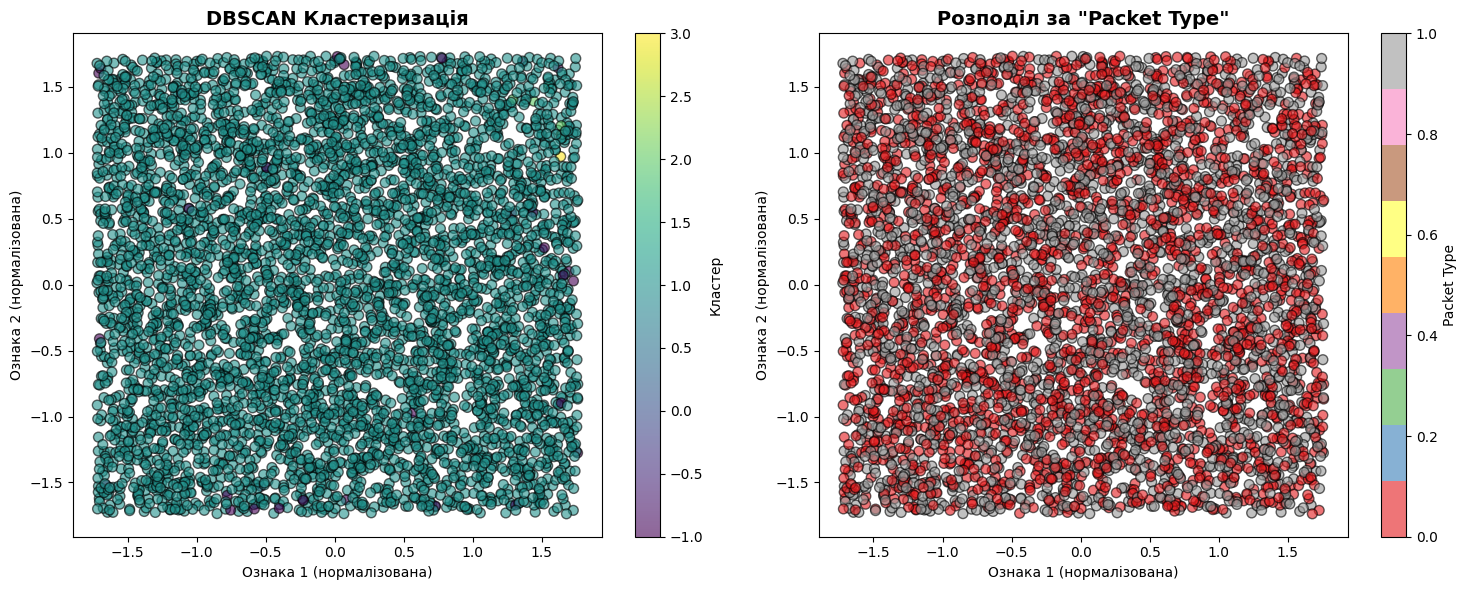

In [7]:
# Дослідження DBSCAN
dbscan_labels, best_params = research_dbscan(df, feature_cols, target_col)




A/B ТЕСТУВАННЯ МОДЕЛЕЙ МАШИННОГО НАВЧАННЯ

✓ Цільову змінну 'Packet Type' закодовано
  Класи: ['Control', 'Data']

⚠ Датасет великий (40000 рядків), використовуємо вибірку з 10000 рядків

Розмір навчальної вибірки: 7000
Розмір тестової вибірки: 3000
Кількість класів: 2

----------------------------------------------------------------------
МОДЕЛЬ A: Logistic Regression (Контрольна група)
----------------------------------------------------------------------
Accuracy: 0.5120
F1-Score: 0.1202
AUC-ROC: 0.4901

----------------------------------------------------------------------
МОДЕЛЬ B: Random Forest (Тестова група)
----------------------------------------------------------------------
Accuracy: 0.5200
F1-Score: 0.4694
AUC-ROC: 0.5174

РЕЗУЛЬТАТИ A/B ТЕСТУВАННЯ

Контрольна група (Logistic Regression):
  Коефіцієнт правильних передбачень: 0.5120
  Стандартне відхилення: 0.4999

Тестова група (Random Forest):
  Коефіцієнт правильних передбачень: 0.5200
  Стандартне відхилення: 0.4996

С

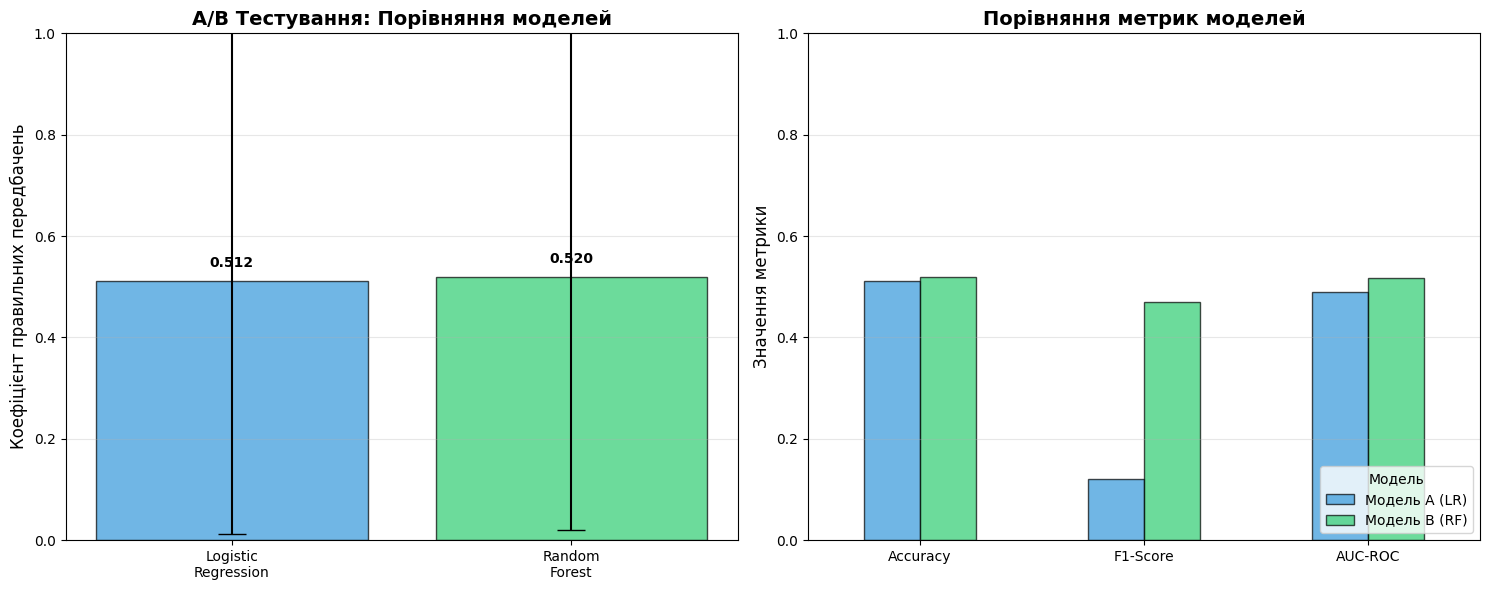


ВИСНОВКИ

1. DBSCAN:
   - Оптимальні параметри: eps=0.5, min_samples=5
   - Знайдено 3 кластерів
   - Виявлено 30 викидів (аномалій)
   - DBSCAN успішно групує схожі записи на основі їх характеристик

2. A/B Тестування:
   - Переможець: Treatment
   - Покращення: 1.56%
   - Результат статистично незначущий
   - A/B тестування дозволяє об'єктивно порівняти моделі


In [8]:
# Дослідження A/B тестування (якщо є цільова змінна)
if target_col:
    ab_results = research_ab_testing(df, feature_cols, target_col)
    
    # Висновки
    print("\n" + "="*70)
    print("ВИСНОВКИ")
    print("="*70)
    print("\n1. DBSCAN:")
    print(f"   - Оптимальні параметри: eps={best_params[0]}, min_samples={best_params[1]}")
    print(f"   - Знайдено {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} кластерів")
    print(f"   - Виявлено {list(dbscan_labels).count(-1)} викидів (аномалій)")
    print(f"   - DBSCAN успішно групує схожі записи на основі їх характеристик")
    
    if ab_results:
        print("\n2. A/B Тестування:")
        print(f"   - Переможець: {ab_results['winner']}")
        print(f"   - Покращення: {ab_results['improvement']:.2f}%")
        if abs(ab_results['z_score']) > 1.96:
            print(f"   - Результат статистично значущий")
        else:
            print(f"   - Результат статистично незначущий")
        print(f"   - A/B тестування дозволяє об'єктивно порівняти моделі")
else:
    print("\n2. A/B Тестування:")
    print(f"   - Не вдалося виконати через відсутність цільової змінної")
